<a href="https://colab.research.google.com/github/akhundMurad/MachineLearning/blob/main/practice/Chapters7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7: Working with Keras: A deep dive

Keras has three API for the model construction:
- Sequantial model - the easiest API which uses Python list, thus sequantial models highly bounded to the simple layer sets.
- Functional API - oriented to the graph-like model architectures. They are flexible and convinient to use.
- Base classes inheritance - the low-level approach. Lack of the access to Keras standard functions and high risk of getting errors.


## 7.2.1 Sequential model

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

# model.weights  # ValueError: Weights for model 'sequential' have not yet been created. Weights are created when the model is first called on inputs or `build()` is called with an `input_shape`.

model.build(input_shape=(None, 3))  # input_shape defines the shape of input package.
# model.weights  # Now we can get weights.

model.summary()

model = keras.Sequential()
model.add(keras.Input(shape=(3,)))  # Using Input to define the shape of input data.
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Tota

## 7.2.2 Functional API

This API should be used if model has several outputs/inputs or nonlinear topology.

#### Simple example

In [3]:
inputs = keras.Input(shape=(3,), name="my_input")  # Called symbolic tensor as it does not hold any real values. Instead this layer defines arguments of the input tensor.
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_4 (Dense)             (None, 64)                256       
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Models with several inputs and outputs.

In [4]:
vocabulary_size = 100000
num_tags = 4
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
description = keras.Input(shape=(vocabulary_size,), name="description")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, description, tags])
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, description, tags], outputs=[priority, department])


# Model fitting

import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
description_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]],
)
model.fit(
    x=[title_data, description_data, tags_data],
    y=[priority_data, department_data],
    epochs=1,
)
model.evaluate(
    x=[title_data, description_data, tags_data],
    y=[priority_data, department_data],
)
priority_preds, department_preds = model.predict(
    [title_data, description_data, tags_data]
)
print(priority_preds, department_preds)

40/40 [==============================] - 1s 14ms/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]] [[1.6542069e-17 0.0000000e+00 1.0000000e+00 1.2503202e-31]
 [6.1973536e-17 0.0000000e+00 1.0000000e+00 2.8951984e-29]
 [8.3692530e-16 0.0000000e+00 1.0000000e+00 4.7868591e-33]
 ...
 [8.9391645e-13 0.0000000e+00 1.0000000e+00 1.1948128e-31]
 [2.3607515e-19 0.0000000e+00 1.0000000e+00 8.9215838e-36]
 [1.1771525e-13 0.0000000e+00 1.0000000e+00 1.3887168e-31]]


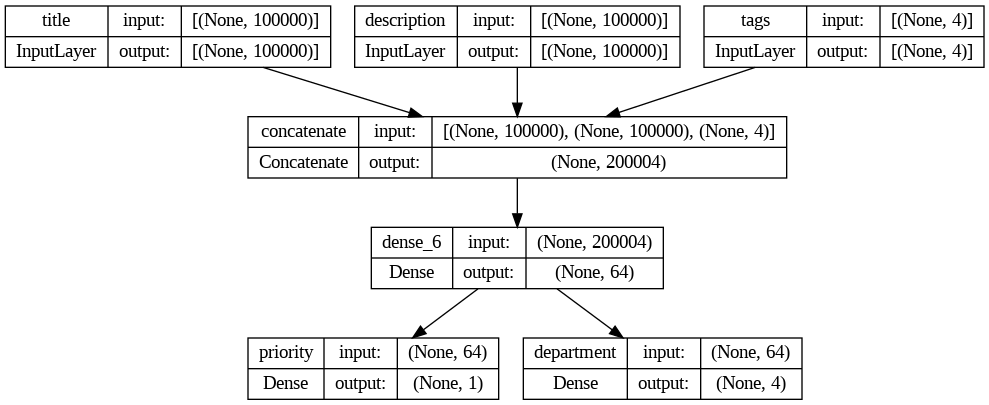

In [11]:
keras.utils.plot_model(model, "ticket_classifier.png", show_shapes=True)

#### The power of functional API

In [6]:
model.layers

In [8]:
model.layers[4].input

<KerasTensor: shape=(None, 200004) dtype=float32 (created by layer 'concatenate')>

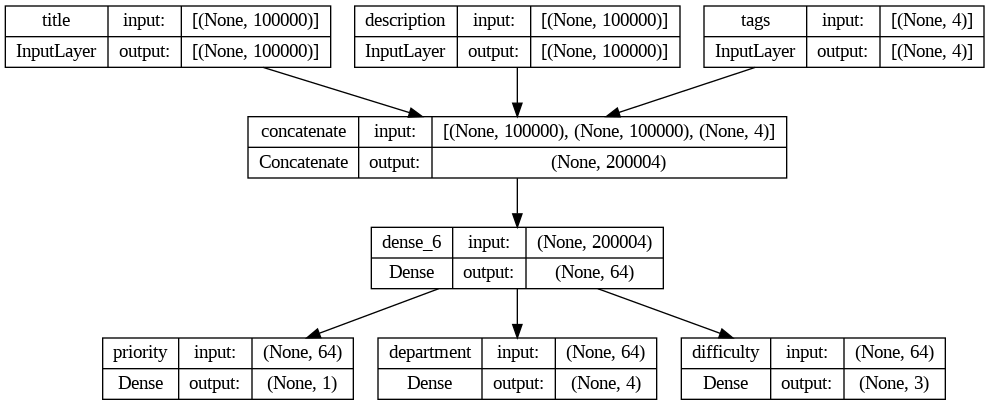

In [10]:
# Create new model, which uses the outputs of intermediate layers:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(inputs=[title, description, tags], outputs=[priority, department, difficulty])

keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

## Custom instances of the Model class

In [12]:
class CustomerTicketModel(keras.Model):
    def __init__(self, num_departments: int) -> None:
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(num_departments, activation="softmax")

    def call(self, inputs: dict):
        title = inputs["title"]
        description = inputs["description"]
        tags = inputs["tags"]

        features = self.concat_layer([title, description, tags])
        features = self.mixing_layer(features)

        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department


custom_model = CustomerTicketModel(num_departments=4)
priority, department = custom_model(
    {"title": title_data, "description": description_data, "tags": tags_data}
)
custom_model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]],
)
custom_model.fit(
    x={"title": title_data, "description": description_data, "tags": tags_data},
    y=[priority_data, department_data],
    epochs=1,
)
custom_model.evaluate(
    x={"title": title_data, "description": description_data, "tags": tags_data},
    y=[priority_data, department_data],
)
priority_preds, department_preds = custom_model.predict(
    {"title": title_data, "description": description_data, "tags": tags_data}
)

40/40 [==============================] - 1s 13ms/step
